# Student-t process regression

[Section 2](02-gaussian_process_regression.ipynb) introduced how we can use Gaussian processes for regression when we assumed normally distributed data. Here, we will instead use a *Student-t process* as introduced in [Rasmussen and Williams (2006)](http://www.gaussianprocess.org/gpml/) and [Shah *et al.* (2014)](https://arxiv.org/abs/1402.4306). 
I also recommend Michael Betancourt's [Robust Gaussian Processes in Stan](https://betanalpha.github.io/assets/case_studies/gp_part1/part1.html) as a resource, for instance to learn more about hyperparameter inference which won't be covered here.

I use `rstan` this time for demonstration.

**I do not take warranty for the correctness or completeness of this document.**

A Student-t process is, just as in the Gaussian setting, used as a prior on a function-space.

\begin{align*}
f(\mathbf{x}) & \sim \mathcal{TP}(\nu, m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')).
\end{align*}

It is parametrized by a *mean function* $m$ that returns a vector of length $n$ and a *kernel function* $k$ that returns a matrix of dimension $n \times n$, where $n$ is the number of samples. In addition the multivariate $t$-distribution is parametrized by its degrees of freedom $\nu$.  For instance, the mean function could be a constant (which we will assume throughout the rest of this notebook), and the kernel could be a radial basis function, i.e.:

\begin{align*}
m(\mathbf{x}) &= \mathbf{0},\\
k(\mathbf{x}, \mathbf{x}') &= \alpha^2 \exp\left(- \frac{1}{2\rho^2} ||\mathbf{x} - \mathbf{x}' ||^2 \right),
\end{align*}

where $\rho$ and $\alpha$ are two hyperparameters we have to optimize. Other than that inference is similar to inference in a Gaussian process. T-processes are, however often suitable when the numer of samples is small. For more details, I recommend the three sources above.

Given some data $D$, the goal is to infer the posterior of the *t-process*. We will use Stan for this, since it will only require to set up the model, while the sampling is done for us. THe posterior has the usual form:

$$
p(f \mid D) \propto p(D \mid d) \ p(f).
$$

In [1]:
suppressMessages(library(MASS))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(colorspace))

suppressMessages(library(rstan))
rstan_options(auto_write = TRUE)

options(mc.cores = parallel::detectCores())
options(repr.plot.width=8, repr.plot.height=3)

## Observation model

First, we create some artificial data using Stan. We'll use a squared exponential kernel function (see the [Stan reference](https://www.google.com/search?q=stan+reference&ie=utf-8&oe=utf-8&client=firefox-b-ab)) with parameters $\rho = 1$ and $\alpha = 1$. With this, and a set of independent variables $\mathbf{x}$, we sample a single random vector from a *t-process*. The square of the sample is then used as the mean of a Poisson distribution, from which we will generate $n$ dependent variables $\mathbf{y}$.

Below you can see the observation model.

In [2]:
model_file = "_models/poisson_t_process.stan"
cat(readLines(model_file), sep="\n")

data {
  int<lower=1> n;
  real x[n];
  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> nu;
}

transformed data {
  matrix[n, n] cov = cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, n));
}

parameters {}
model {}

generated quantities {
  vector[n] tp = multi_student_t_rng(nu, rep_vector(0, n), cov);  
  vector[n] y;
  for (i in 1:n) {    
    y[i] = poisson_log_rng(tp[i]);    
  }
}


Here, we set up everything required for the sampler.

In [3]:
n <- 100
x <- seq(0, 10, length.out = n)

alpha <- 1
rho   <- 1
nu    <- 1

In [4]:
dat <- list(
    alpha = alpha,
    rho = rho,
    nu = nu,
    N = n, 
    x = x
)

Then we sample using NUTS.

In [24]:
fit <- stan(
    file=model_file, 
    data=dat, 
    iter=1, 
    chains=1, 
    seed=1,
    algorithm="Fixed_param"
)


SAMPLING FOR MODEL 'poisson_t_process_posterior' NOW (CHAIN 1).
Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.000123 seconds (Sampling)
               0.000123 seconds (Total)



In [6]:
tp <- extract(fit)$tp[1,]
y  <- extract(fit)$y[1,]

In [7]:
y

[1] 24 31 29 27 17 21 22 19 15 12 10  6  6  3  3  1  3  2  1  0  0  0  0  0  0
 [26]  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 [51]  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  1  1
 [76]  2  2  2  2  3  2  3  3  5  6  1  2  7  6  4  8 12 12 15 15 19 20 18 12 25

In order to infer the posterior of the t-process later, we randomly define 50 observations, i.e. we use 50 of these samples as data. I still plot the other samples for completness.

In [8]:
observed_idx <- sort(sample(seq(n), size = 50, replace = FALSE))
n_obs <- length(observed_idx)
X_obs <- x[observed_idx]
y_obs <- y[observed_idx]

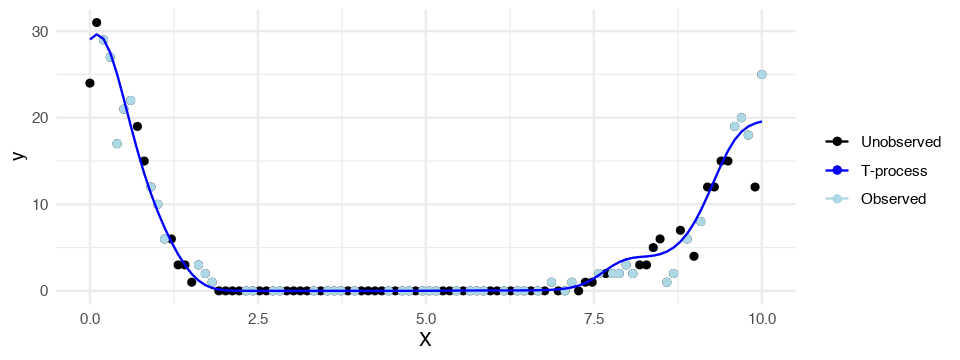

In [9]:
data.frame(X=x, f=tp, y=y) %>%
    ggplot() +
    geom_point(aes(X, y, color="black")) +
    geom_point(data=data.frame(X=X_obs, y=y_obs),
               aes(X, y, color="lightblue")) +
    geom_line(aes(X, exp(f), color="blue")) +
    theme_minimal() +
    scale_colour_manual(
        name = "", 
        values=c('black'='black', 'blue'='blue', "lightblue"="lightblue"), 
        labels = c('Unobserved','T-process', "Observed"))

## Prior

Sampling data from a t-process prior, and then simulating observations $\mathbf{y}$ from the prior is staightforward, since it is basically a draw from a multivariate t-distribution. We can use the same Stan-file as above, to create some priors.

In [10]:
priors <- stan(
    file=model_file, 
    data=dat, 
    iter=10, 
    chains=1, 
    seed=23,
    algorithm="Fixed_param"
)


SAMPLING FOR MODEL 'poisson_t_process' NOW (CHAIN 1).
Iteration: 1 / 10 [ 10%]  (Sampling)
Iteration: 2 / 10 [ 20%]  (Sampling)
Iteration: 3 / 10 [ 30%]  (Sampling)
Iteration: 4 / 10 [ 40%]  (Sampling)
Iteration: 5 / 10 [ 50%]  (Sampling)
Iteration: 6 / 10 [ 60%]  (Sampling)
Iteration: 7 / 10 [ 70%]  (Sampling)
Iteration: 8 / 10 [ 80%]  (Sampling)
Iteration: 9 / 10 [ 90%]  (Sampling)
Iteration: 10 / 10 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               0.001137 seconds (Sampling)
               0.001137 seconds (Total)



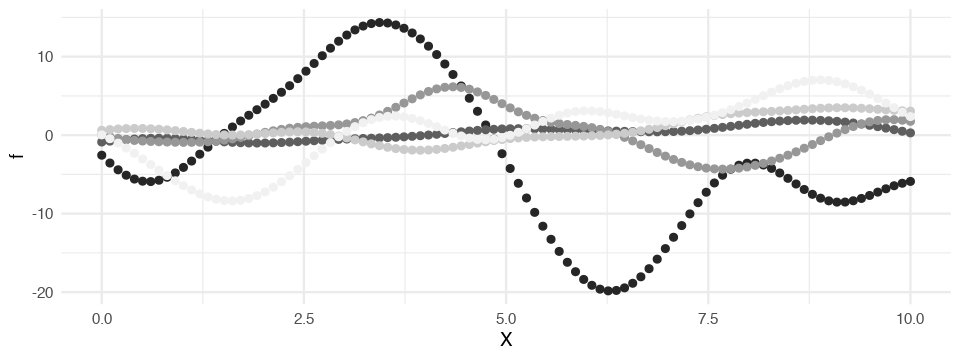

In [11]:
data.frame(
    X=rep(x, 5),
    f=as.vector(t(extract(priors)$tp[1:5,])),
    C=rep(paste0("F", seq(5)), each=length(x))) %>%
    ggplot() +
    geom_point(aes(X, f, color=C)) +
    scale_color_discrete_sequential("Grays") +
    theme_minimal() +
    guides(color=FALSE)

##  Posterior Predictive

Similar as when we do classification using GP-priors, we often find ourselves in situations where we don't have closed-form solutions for the posterior. In that case we need to refer to sampling or variational inference.

To create posterior samples, we need to expand our primary Stan file a little and specify distribution of the latent t-process.

In [12]:
model_file = "_models/poisson_t_process_posterior.stan"
cat(readLines(model_file), sep="\n")

data {
  int<lower=1> n;
  int<lower=1> n_obs;
    
  int<lower=1, upper=n> observed_idx[n_obs];
  int y_observed[n_obs];
  real x[n];

  real<lower=0> rho;
  real<lower=0> alpha;
  real<lower=0> nu;
}

transformed data {
  matrix[n, n] cov = cov_exp_quad(x, alpha, rho)
                     + diag_matrix(rep_vector(1e-10, n));
}

parameters {
  vector[n] tp;
}


model {
  tp ~ multi_student_t(nu, rep_vector(0, n), cov);  
  y_observed ~ poisson_log(tp[observed_idx]);
}

generated quantities {  
  vector[n] y;
  for (i in 1:n)
    y[i] = poisson_log_rng(tp[i] + 1e-6);
}


Inference is then done as before.

In [13]:
dat <- list(
    n = n,
    n_obs = n_obs,     
    observed_idx=observed_idx,
    y_observed=y_obs,
    x = x,
    alpha = alpha,
    rho = rho,
    nu = nu
)

In [21]:
post <- stan(
    file=model_file, 
    data=dat, 
    iter=1000, 
    chains=1, 
    seed=23
)


SAMPLING FOR MODEL 'poisson_t_process_posterior' NOW (CHAIN 1).

Gradient evaluation took 0.000133 seconds
1000 transitions using 10 leapfrog steps per transition would take 1.33 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 700 / 1000 [ 70%]  (Sampling)
Iteration: 800 / 1000 [ 80%]  (Sampling)
Iteration: 900 / 1000 [ 90%]  (Sampling)
Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 68.7123 seconds (Warm-up)
               72.266 seconds (Sampling)
               140.978 seconds (Total)



Warning message:
“There were 500 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In the end, we compute the mean from the posterior and plot it along with the original data.

In [22]:
params <- extract(post)
posterior.eta.mean <- apply(exp(params$tp), 2, mean)

Warning message:
“Removed 1 rows containing missing values (geom_path).”

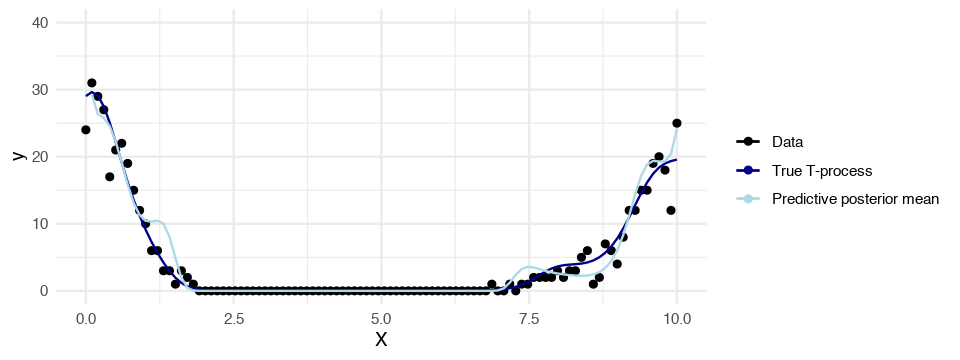

In [26]:
data.frame(X = x, f = posterior.eta.mean) %>%
    ggplot() +
    geom_point(data=data.frame(X=x, y=y), aes(X, y, color="black")) +
    geom_line(data=data.frame(X=x, f=exp(tp)), aes(X, f, color="darkblue")) +
    geom_line(aes(X, f, color="lightblue")) +
    scale_y_continuous(limits = c(0, 40)) +
    theme_minimal() +
    scale_colour_manual(
        name = "", 
        values=c('black'='black', 'darkblue'='darkblue', "lightblue"="lightblue"), 
        labels = c('Data', 'True T-process', 'Predictive posterior mean'))